### 1. Load and instantiate project

In [18]:
using DrWatson, Pkg
Pkg.instantiate()
@quickactivate "JuMP-DrWatson Example"

### 2. Load data for customers and facilities

In [19]:
using CSV, DataFrames

In [20]:
C = CSV.read(datadir("customers.csv"), DataFrame)

,ID,x_coord,y_coord,demand
,Int64,Float64,Float64,Int64
1,1,0.505181,0.830769,25
2,2,0.448435,0.521569,21
3,3,0.132909,0.315383,18
4,4,0.245557,0.4133,20
5,5,0.744088,0.255979,27
6,6,0.531909,0.605737,19
7,7,0.229053,0.872867,13
8,8,0.962639,0.224656,19
9,9,0.488926,0.125628,21


In [21]:
F = CSV.read(datadir("facilities.csv"), DataFrame)

,ID,x_coord,y_coord,capacity,fixed_cost
,Int64,Float64,Float64,Int64,Float64
1,1,0.275855,0.436745,118,0.4
2,2,0.950362,0.22688,104,0.67
3,3,0.718727,0.191534,136,0.26
4,4,0.788685,0.81876,112,0.82
5,5,0.0490049,0.206744,138,0.93
6,6,0.254498,0.640604,140,0.74
7,7,0.212028,0.757836,131,0.62
8,8,0.306419,0.783723,129,0.09
9,9,0.28817,0.620169,122,0.62


### 3. Visualize locations of customers and potential facilities

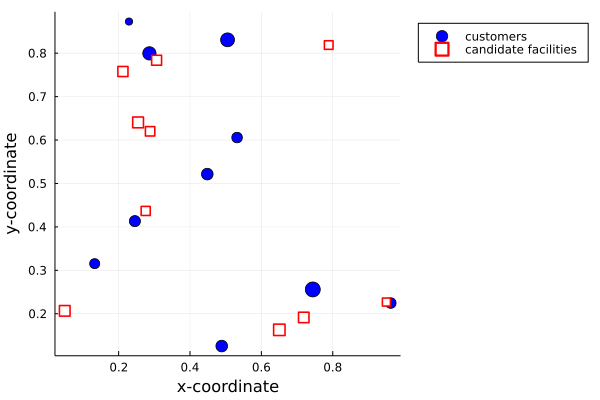

In [22]:
include(srcdir("plot.jl"))
fig1 = show_network(C, F)

### 4. Build MILP Model

$ 
min 
\sum_{f \in F}\alpha_f \cdot y_f \quad \quad \quad \quad \text{installation cost}\\ 
\quad \quad + \\ 
\quad \quad \sum_{f \in F}\sum_{c \in C}d_{f,c} \cdot x_{f,c} \quad \text{transportation cost}\\ 
\quad \quad + \\ 
\quad \quad \sum_{c \in C}(q_c - \sum_{f \in F} x_{f,c}) \quad \text{unfulfilled demand}
$

$
s.t. \\
\quad \quad \sum_{f \in F} x_{f,c} \le q_c \quad \forall c \in C \quad \text{demand constraint} \\
\quad \quad \sum_{c \in C} x_{f,c} \le k_f \cdot y_k \quad \forall f \in F \quad \text{capacity constraint} \\
\quad \quad y_f \in \{0,1\} \quad \forall f \in F\\
\quad \quad 0 \le x_{f,c} \le q_c \quad \forall f \in F, c \in C
$

In [23]:
using JuMP, HiGHS
include(srcdir("utils.jl"))

add_facilities (generic function with 1 method)

In [40]:
#calculate euclidean distance
function dist(f, c, F, C)
    Δx = F[f,:x_coord] - C[c,:x_coord]
    Δy = F[f,:y_coord] - C[c,:y_coord]
    δ = √(Δx^2 + Δy^2)
end

#create model and define solver to use (HiGHS)
function facility_location(F, C, log_file="")
    m = Model(HiGHS.Optimizer)
    #get distance matrix
    @expression(m, α[f ∈ F.ID], F.fixed_cost[f])
    @expression(m, d[f ∈ F.ID, c ∈ C.ID], dist(f,c,F,C))
    @expression(m, q[c ∈ C.ID], C.demand[c])
    @expression(m, k[f ∈ F.ID], F.capacity[f])
    #create variables
    @variable(m, y[f ∈ F.ID], Bin)
    @variable(m, 0 ≤ x[f ∈ F.ID, c ∈ C.ID] ≤ q[c])
    #create constraints
    @constraint(m, demand[c ∈ C.ID], ∑(x[f,c] for f ∈ F.ID) ≤ q[c])
    @constraint(m, capacity[f ∈ F.ID], ∑(x[f,c] for c ∈ C.ID) ≤ k[f] * y[f])
    #define objective function
    @objective(m, Min, 
        ∑(α[f] * y[f] for f ∈ F.ID) 
        + 
        ∑(d[f,c] * x[f,c] for f ∈ F.ID, c ∈ C.ID)
        +
        ∑(q[c] - ∑(x[f,c] for f in F.ID) for c in C.ID)
    )
    #turn off output
    set_optimizer_attribute(m, "log_to_console", false)
    if !isempty(log_file)
        set_optimizer_attribute(m, "log_file", log_file)
    end
    
    return m
end

m = facility_location(F,C)
latex_formulation(m)

$$ \begin{aligned}
\min\quad & 0.4 y_{1} + 0.67 y_{2} + 0.26 y_{3} + 0.82 y_{4} + 0.93 y_{5} + 0.74 y_{6} + 0.62 y_{7} + 0.09 y_{8} + 0.62 y_{9} + 0.64 y_{10} - 0.5441004317017614 x_{1,1} - 0.8077015683346583 x_{1,2} - 0.8124836132548482 x_{1,3} - 0.9616890756780514 x_{1,4} - 0.4980855528184429 x_{1,5} - 0.6932071566355149 x_{1,6} - 0.561374829892879 x_{1,7} - 0.28121339177575966 x_{1,8} - 0.622915269845732 x_{1,9} - 0.6370304879704713 x_{1,10} - 0.2497545146844481 x_{2,1} - 0.4179582501546645 x_{2,2} - 0.17777055473369197 x_{2,3} - 0.27095777525108644 x_{2,4} - 0.7916839309829082 x_{2,5} - 0.4355222330718864 x_{2,6} - 0.03171026938343835 x_{2,7} - 0.9875224704718587 x_{2,8} - 0.5275860118691116 x_{2,9} - 0.12306685139969176 x_{2,10} - 0.32603905880193496 x_{3,1} - 0.5734073038327918 x_{3,2} - 0.4012335434015637 x_{3,3} - 0.47743859134800826 x_{3,4} - 0.9307440115538103 x_{3,5} - 0.5456157048565226 x_{3,6} - 0.1609560594756524 x_{3,7} - 0.7538492240122252 x_{3,8} - 0.7609345581253482 x

In [41]:
optimize!(m)
termination_status(m)

OPTIMAL::TerminationStatusCode = 1

### 5. Visualize Solution

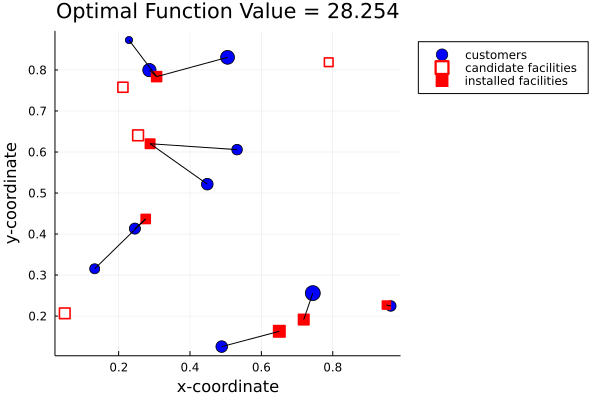

In [25]:
fig2 = show_network(C, F, m)

### 6. Sensitivity Study
Increase the number of customers and candidate facilities from 10 to 20.

In [26]:
#define parameters to change
num_facilities = collect(11:15)
num_customers = collect(11:15)
all_params = @strdict num_facilities num_customers
params = dict_list(all_params)

#define facilities and customers
Fnew = add_facilities(F, maximum(num_facilities))
Cnew = add_customers(C, maximum(num_customers))

#define function to call MILP model
function run_model(d)
    #get parameters for sensitivity study
    @unpack num_facilities, num_customers = d
    #build and run model
    F0 = Fnew[1:num_facilities,:]
    C0 = Cnew[1:num_customers,:]
    m = facility_location(F0, C0, datadir("sensitivity",savename("log",d,"txt")))
    optimize!(m)
    #save objective function value and number of facilities used
    result = Dict(
        "facilities_available" => num_facilities,
        "customers" => num_customers,
        "objective_value" => objective_value(m),
        "facilities_installed" => sum(value.(m[:y])),
        "installed_capacity" => sum(value.(m[:x])),
        "solution_time" => solve_time(m),
        "relative_gap" => relative_gap(m),
        "node_count" => node_count(m)
    )

    return result
end

run_model (generic function with 1 method)

In [27]:
#run sensitivity study and save outputs
for (i,d) in enumerate(params)
    res = run_model(d)
    wsave(datadir("sensitivity", savename("results", d, "jld2")), res)
end

┌ Info: Scanning folder c:\Users\HD\Documents\JuMP-DrWatson-Example\data\sensitivity for result files.
└ @ DrWatson C:\Users\HD\.julia\packages\DrWatson\S4dYA\src\result_collection.jl:115
┌ Info: Added 25 entries.
└ @ DrWatson C:\Users\HD\.julia\packages\DrWatson\S4dYA\src\result_collection.jl:191


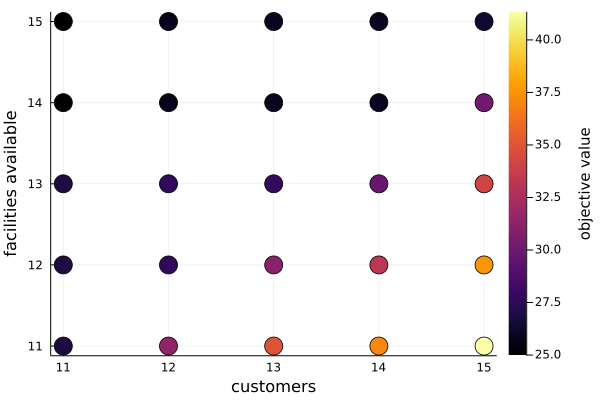

In [28]:
#analyze results
results = collect_results(datadir("sensitivity"))
fig3 = scatter(
    results.customers, 
    results.facilities_available,
    marker_z = results.objective_value,
    xlabel = "customers",
    ylabel = "facilities available",
    colorbar_title = "\nobjective value",
    rightmargin = 5mm,
    markersize = 10,
    colorbar = true,
    legend = :none
)

### 7. Save figures

In [29]:
savefig(fig1,plotsdir("network.png"))
savefig(fig2,plotsdir("network_optimal.png"))
savefig(fig3,plotsdir("sensitivity.png"))